In [1]:
import torch
import requests 
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
)


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url ="https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))
device = "cuda" if torch.cuda.is_available() else "cpu"

/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
pipe.enable_attention_slicing()
pipe.safety_checker = lambda images, clip_input: (images, None)
generator = torch.Generator(device=device).manual_seed(42)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

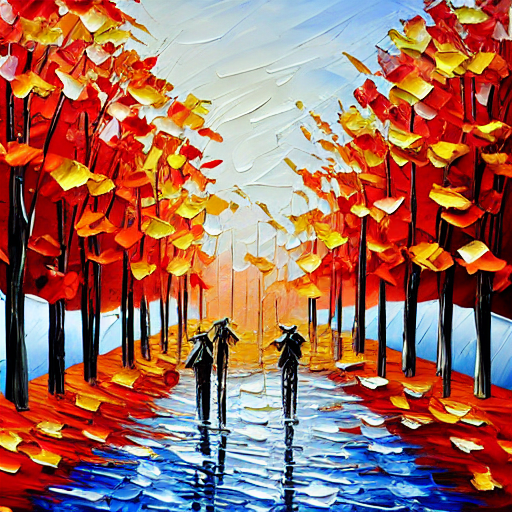

In [3]:
generator = torch.Generator(device=device).manual_seed(42)
pipe_output = pipe(prompt="Pallette knife painting of an autumn cityscape",
                   negative_prompt="Oversaturated, blurry, low quality",
                   height=512, width=512,
                   guidance=8,
                   num_inference_steps=35,
                   generator=generator)
pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

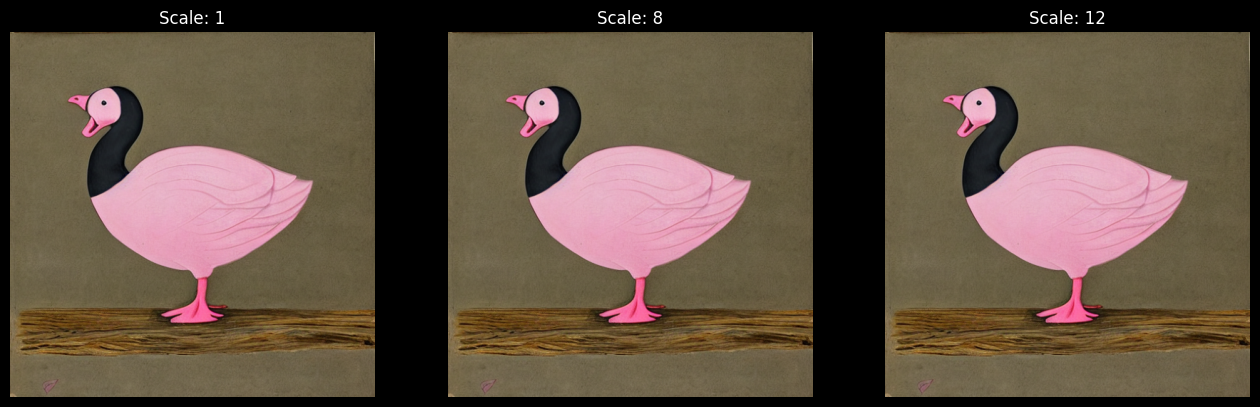

In [4]:
cfg_scales = [1, 8, 12]
prompt = "A goose with a pink hat" 
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(prompt=prompt,
                       negative_prompt="A blurry, low quality image",
                       height=512, width=512,
                       guidance=cfg_scales[i],
                       num_inference_steps=35,
                       generator=torch.Generator(device=device).manual_seed(42)).images[0]
    ax.imshow(im)
    ax.axis("off")
    ax.set_title(f"Scale: {cfg_scales[i]}")
plt.show()

In [5]:
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


In [6]:
images = torch.rand(1, 3, 512, 512).to(device)
with torch.no_grad():
    latents = .18215 * pipe.vae.encode(images).latent_dist.mean
print("encoded latents shape:", latents.shape) 

with torch.no_grad():
    images = pipe.vae.decode(latents / .18215).sample
print("decoded images shape:", images.shape)

encoded latents shape: torch.Size([1, 4, 64, 64])
decoded images shape: torch.Size([1, 3, 512, 512])


In [7]:
a = 1 * 4 * 64 * 64
b = 1 * 32 * 512 * 512
a, b, a / b

(16384, 8388608, 0.001953125)

In [8]:
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("input id -> decoded token")
for i in input_ids[0]:
    print(f"{i} -> {pipe.tokenizer.decode(i)}")
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)
text_embeddings[0]

input id -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 768])


tensor([[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
        [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
        [-0.1969,  0.2920,  1.3066,  ..., -1.9838, -1.2365,  1.7627],
        ...,
        [-0.8758, -1.1433,  0.7593,  ..., -1.4371,  1.8236,  0.5033],
        [-1.0936, -0.5929,  0.0651,  ..., -1.2761,  1.6522, -0.2254],
        [-0.0384, -0.5579,  0.3285,  ..., -1.1071,  0.0645, -0.0122]],
       device='cuda:0')

same result but one step get text embedding:

In [9]:
text_embeddings = pipe.encode_prompt(prompt="A painting of a flooble",
        device=device, num_images_per_prompt=1, do_classifier_free_guidance=False,
        negative_prompt='')[0]
print(text_embeddings.shape, text_embeddings[0])

torch.Size([1, 77, 768]) tensor([[-3.8838e-01,  2.2944e-02, -5.2197e-02,  ..., -4.8988e-01,
         -3.0660e-01,  6.7454e-02],
        [ 2.9031e-02, -1.3258e+00,  3.0846e-01,  ..., -5.2568e-01,
          9.7681e-01,  6.6517e-01],
        [-1.9689e-01,  2.9201e-01,  1.3066e+00,  ..., -1.9838e+00,
         -1.2365e+00,  1.7627e+00],
        ...,
        [ 2.4374e-01, -2.7478e-01, -5.1534e-01,  ..., -5.0242e-01,
         -2.1152e-02, -1.4191e+00],
        [ 2.5359e-01, -2.8937e-01, -5.0224e-01,  ..., -5.0304e-01,
         -1.0045e-03, -1.4163e+00],
        [ 2.7924e-01, -2.1175e-01, -4.8380e-01,  ..., -4.7549e-01,
          2.6984e-02, -1.4241e+00]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [10]:
# make psuedo input
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 768).to(device)

# run the model
with torch.no_grad():
    unet_output = pipe.unet(sample=latents, timestep=timestep, encoder_hidden_states=text_embeddings).sample
print("Unet output shape:", unet_output.shape)


Unet output shape: torch.Size([1, 4, 64, 64])


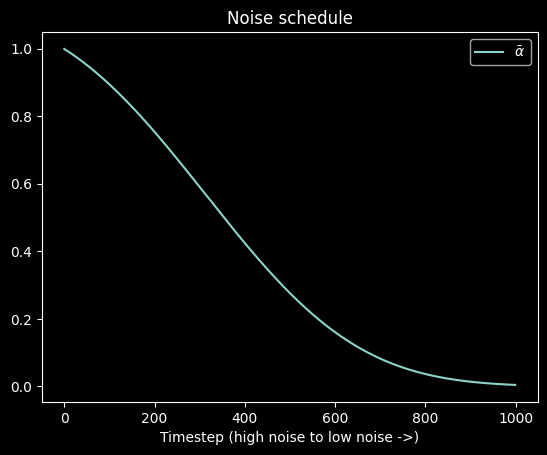

In [11]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel("Timestep (high noise to low noise ->)")
plt.title('Noise schedule')
plt.legend()

In [12]:
# %%capture
# %pip install scipy

Schduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.26.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



  0%|          | 0/35 [00:00<?, ?it/s]

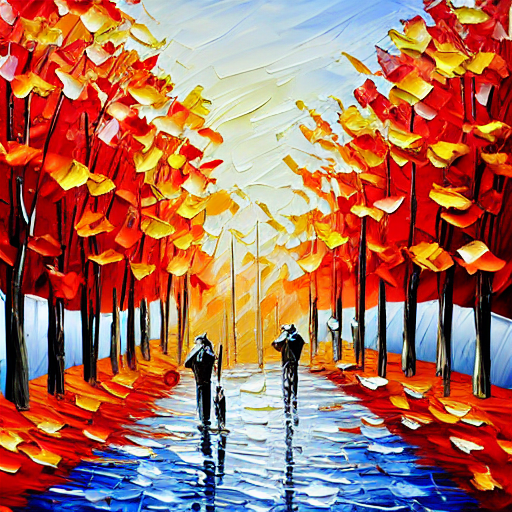

In [3]:
from diffusers import LMSDiscreteScheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
print('Schduler config:', pipe.scheduler)
pipe(prompt="Pallette knife painting of an autumn cityscape",
     negative_prompt="Oversaturated, blurry, low quality",
     height=512, width=512,
     num_inference_steps=35,
     generator=generator).images[0]

In [7]:
guidance_scale = 8
num_inference_steps = 30
prompt = "Beautiful picutre of a wave breaking"
negative_prompt = "Blurry, low quality, oversaturated, zoomed in, warped"

text_embeddings = pipe.encode_prompt(prompt=prompt, device=device,
    num_images_per_prompt=1, do_classifier_free_guidance=True,
    negative_prompt=negative_prompt)[0]

latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma


pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

pipe.numpy_to_pil(image)[0]






Traceback (most recent call last):
  File "/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'tensor' is not defined


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 5.80 GiB of which 113.19 MiB is free. Including non-PyTorch memory, this process has 5.63 GiB memory in use. Of the allocated memory 5.21 GiB is allocated by PyTorch, and 327.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)